## This project is to perform analysis using Airbnb listing dataset from Seattle and Boston.  Analysis includes natrual language analysis, visulizations, comparative analysis and predictions using regression.

In [1]:
#Importing libraries and packages for data analysis and visulization 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(style="ticks")

import collections
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_squared_error 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

In [2]:
df_sea = pd.read_csv('./seattle/listings.csv')
df_bos = pd.read_csv('./boston/listings.csv')                                                                                       #encoding= 'latin1' , dataset use latin1 as reference because we will have UnicodeDecodeError: "utf-8" codec can"t decode error
                                                            
num_rows_sea =df_sea.shape[0]
num_cols_sea= df_sea.shape[1]

num_rows_bos =df_bos.shape[0]
num_cols_bos= df_bos.shape[1]

most_missing_cols_sea = set(df_sea.columns[df_sea.isnull().mean() > 0.75])
most_missing_cols_bos = set(df_bos.columns[df_bos.isnull().mean() > 0.75])

print(num_rows_sea, num_cols_sea, most_missing_cols_sea)
print(num_rows_bos, num_cols_bos, most_missing_cols_bos)

3818 92 {'square_feet', 'license'}
3585 95 {'neighbourhood_group_cleansed', 'weekly_price', 'monthly_price', 'square_feet', 'jurisdiction_names', 'has_availability', 'license'}


### Prepare Data

In [3]:
# filter dataset

def filter_data(df):
    '''
    INPUT
    df - pandas dataframe for listing data
    
    OUTPUT
    df_new - cleaned dataset in following rules: 
    1. unrelevant columns are removed
    2. dollar values converted to number
    3. missing values are dropped or imputed using mean or mode
    '''
    remove_columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', ## 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', ## 'neighbourhood'
       'street', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'square_feet', 'minimum_nights','maximum_nights', 
       'weekly_price', 'monthly_price', 'calendar_updated', 
       'availability_30', 'availability_60', 'availability_90','availability_365', 'calendar_last_scraped',  
       'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count']
    
    # seattle dataset does not has column: 'access', 'interaction', 'house_rules'
    
    # deep copy df
    df_new = df.copy()
    
    # drop all unrelevant columns
    df_new.drop(remove_columns, axis=1, inplace=True)
    
    # drop all columns with unique values
    for col in df_new.columns:
        if len(df_new[col].unique()) == 1:
            df_new.drop(col, inplace=True, axis=1)

    # collect all columns related to review
    review_columns = []
    for col in df_new:
        if 'review' in col:
            review_columns.append(col)
    
    #convert all dollar related columns values from string to number
    df_new['price'] = df_new['price'].replace('[\$,]', '', regex=True).astype(float)
    df_new['security_deposit'] = df_new['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
    df_new['cleaning_fee'] = df_new['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
    df_new['extra_people'] = df_new['extra_people'].replace('[\$,]', '', regex=True).astype(float)
    
    #convert all percentage columns values to float number
    df_new['host_response_rate'] = df_new['host_response_rate'].replace('[\%,]', '', regex=True).astype(float)/100
    df_new['host_acceptance_rate'] = df_new['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)/100
    
    #generate overall review score using reviews_per_month * review_scores_rating
    df_new['overall_review_score'] = df_new['reviews_per_month'] * df_new['review_scores_rating']/100

    #remove other review columns
    df_new = df_new.drop(review_columns, axis=1)
    
    return df_new

In [4]:
# convert multi-catigories data column value into length of elements in its value
def process_multi_cat_col(df, colname):
    col_loc = df.columns.get_loc(colname)
    
    for i, row in enumerate(df[colname]):
        df.iloc[i, col_loc] = str(row).replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').replace(' ','')
        df.iloc[i, col_loc] = len(df.iloc[i, col_loc].split(','))
    return df

In [5]:
# filter data for both seattle and boston dataset
df_sea_fl = filter_data(df_sea)
df_bos_fl = filter_data(df_bos)

# drop neighbourhood_group_cleansed from seattle dataset
df_sea_fl.drop(['neighbourhood_group_cleansed'], axis=1, inplace=True)

# drop columns ['access' 'interaction' 'house_rules'] from boston dataset
df_bos_fl.drop(['access','interaction','house_rules'], axis=1, inplace=True)

# clean up multi-categorical columns: amenities and host_verifications
df_sea_fl = process_multi_cat_col(df_sea_fl, 'amenities')
df_sea_fl = process_multi_cat_col(df_sea_fl, 'host_verifications')
df_bos_fl = process_multi_cat_col(df_bos_fl, 'amenities')
df_bos_fl = process_multi_cat_col(df_bos_fl, 'host_verifications')


In [6]:
# double check column numbers are the same
print(len(df_sea_fl.columns))
print(len(df_bos_fl.columns))

29
29


## Data exploration

### Q: Which neighborhood has the highest number of listings in Boston and Seattle?

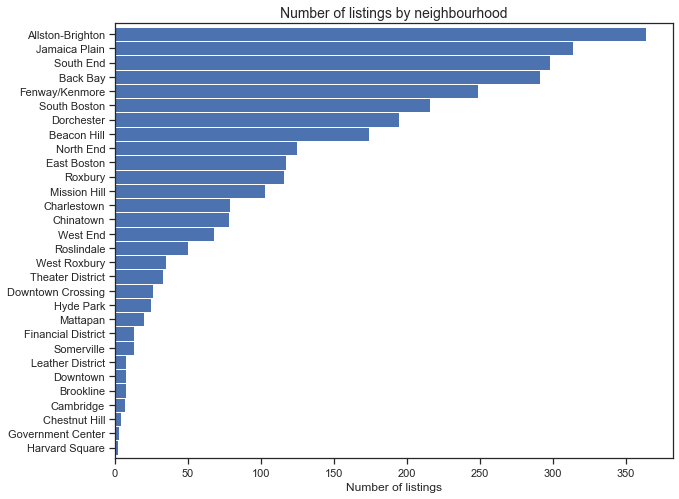

In [7]:
#Seeing which neighborhood has the highest number of listings neighbourhood_cleansed neighbourhood
feq = df_bos_fl['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10,8), color ='b', width= 1)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

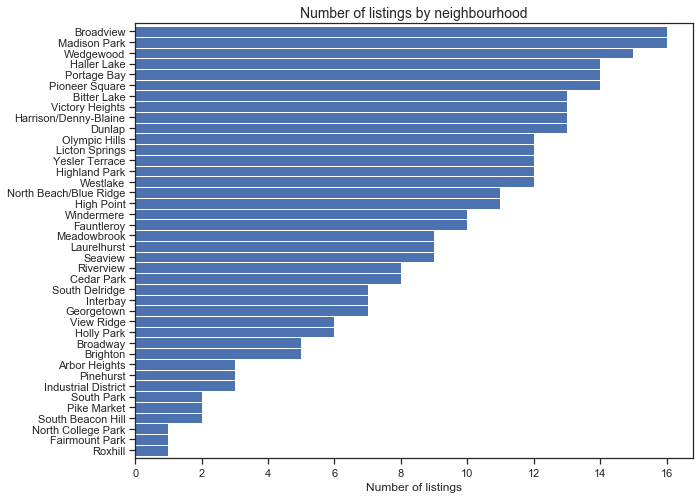

In [8]:
#Seeing which neighborhood has the highest number of listings neighbourhood_cleansed neighbourhood
#for Seattle area, there are too many neighbourhood so we will look at top 40
feq = df_sea_fl['neighbourhood'].value_counts().sort_values(ascending=True)[:40] 
feq.plot.barh(figsize=(10,8), color ='b', width= 1)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

## Natrual language analysis

### How we could describe the vibe of Boston neighborhoods? 

In [9]:
# clean up null values for neighborhood_overview column 
df_bos_fl = df_bos_fl.fillna(value={"neighborhood_overview": ''})

# get stopwords from natural language toolkit
stopwords_eng = stopwords.words('english')
# additional keywords 
stopwords_in_context1 = ['many','several','local','short','great','whole','next']
stopwords_in_context2 = ['also','away','mi','mile','1','2','one','street','located']
stopwords_in_context3 = ['boston','neighborhood','neighborhoods','jamaica','plain','south','end','north','back','bay','east','fenway']
stopwords_eng.extend(stopwords_in_context1)
stopwords_eng.extend(stopwords_in_context2)
stopwords_eng.extend(stopwords_in_context3)

# we will be looking at top 10 Boston neighborhood with most number of listings
top10 = df_bos_fl['neighbourhood'].value_counts().sort_values(ascending=False)[:10]
neighbourhoods = top10.keys().values.tolist()

# process top 10 keywords from neighborhood_overview of each neighbourhood
# we will filter the keyword using nltk pos_tag by only taking adjectives
neighbourhoods_keywords = {}

for n in neighbourhoods:
    neighborhood_overview = ' '.join(df_bos_fl[df_bos_fl['neighbourhood']==n]["neighborhood_overview"])
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    neighborhood_overview = pattern.sub('', neighborhood_overview.lower())
    words = re.findall(r'\w+', neighborhood_overview)
    words_common = collections.Counter(words).most_common(100)
    top_words = []
    for w in words_common:
        text = nltk.word_tokenize(w[0])
        tag = nltk.pos_tag(text)
        if tag[0][1] == 'JJ':
            top_words.append(w)
#         top_words.append(w)
        if len(top_words) >= 10:
            break
    neighbourhoods_keywords[n] = top_words

#convert neighbourhoods_keywords into dict of dict
neighbourhoods_keywords_dict = {}
for k,v in neighbourhoods_keywords.items():
    inner_dict = {}
    for item in v:
        inner_dict[item[0]] = item[1]
    neighbourhoods_keywords_dict[k] = inner_dict    

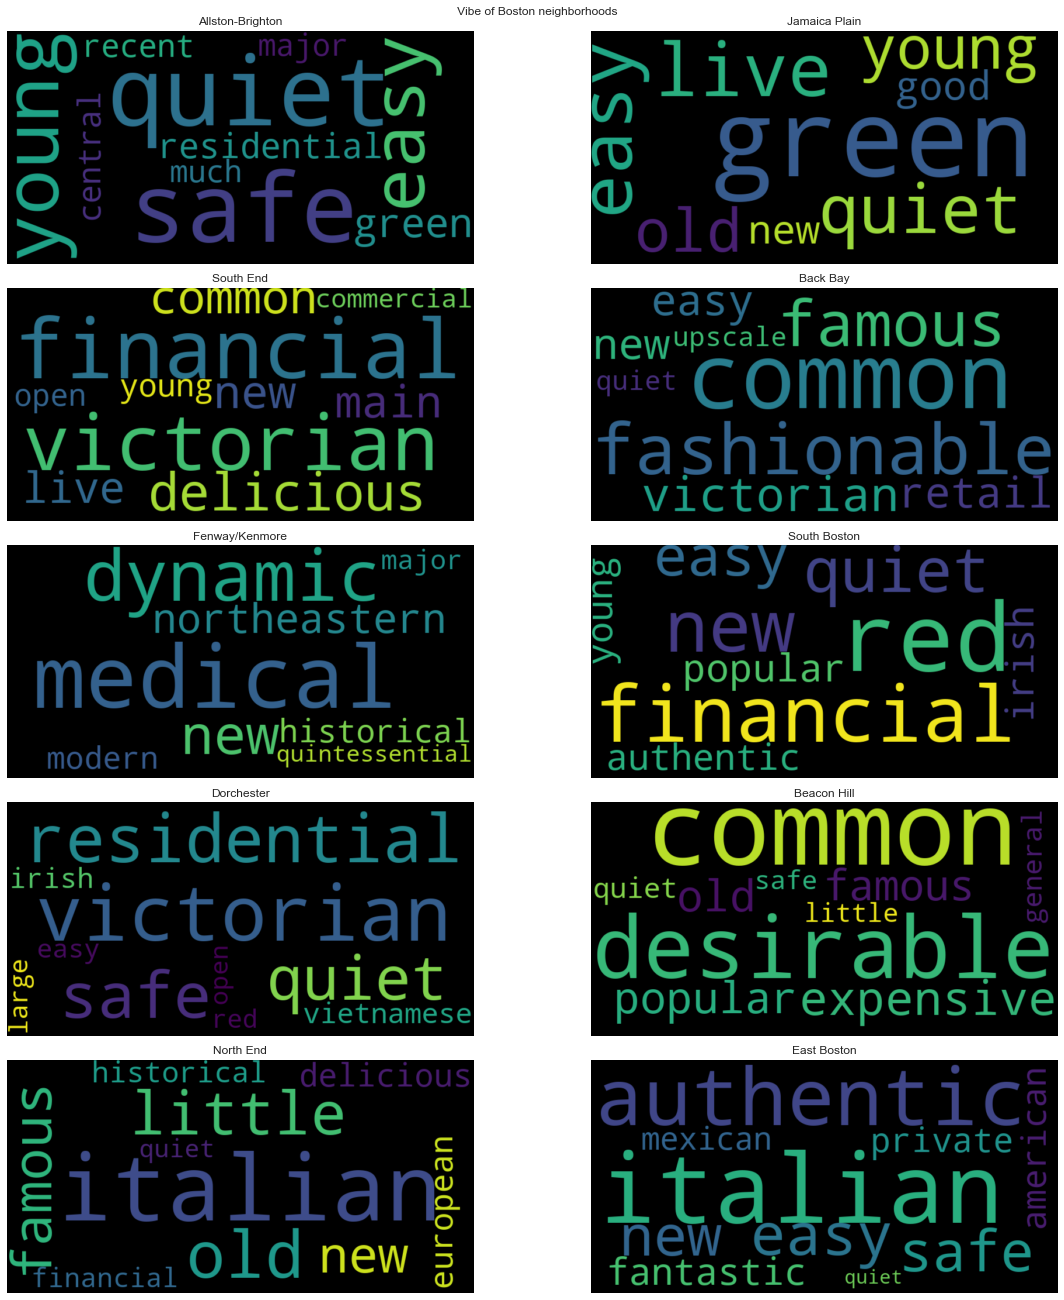

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18,18))
x = 0
y = 0
for k,v in neighbourhoods_keywords_dict.items():
   cloud = WordCloud(width=800, height=400)
   cloud.generate_from_frequencies(frequencies=v)
   axs[x][y].imshow(cloud, interpolation="bilinear")
   axs[x][y].title.set_text(k)
   axs[x][y].axis("off") 
   if y == 0:
    y = y + 1
   elif y == 1:
    y = 0
    x = x + 1

fig.tight_layout(pad=1.0)    
fig.suptitle("".join(["   Vibe of Boston neighborhoods"]), y=1.00)
plt.show()


### How we could describe the vibe of Seattle neighborhoods? 

In [11]:
# clean up null values for neighborhood_overview column 
df_sea_fl = df_sea_fl.fillna(value={"neighborhood_overview": ''})

# get stopwords from natural language toolkit
stopwords_eng = stopwords.words('english')
# additional keywords 
stopwords_in_context1 = ['many','several','local','short','great','whole','next']
stopwords_in_context2 = ['also','away','mi','mile','1','2','one','street','located']
stopwords_in_context3 = ['seattle','neighborhood','neighborhoods']
stopwords_eng.extend(stopwords_in_context1)
stopwords_eng.extend(stopwords_in_context2)
stopwords_eng.extend(stopwords_in_context3)

# we will be looking at top 10 Boston neighborhood with most number of listings
top10 = df_sea_fl['neighbourhood'].value_counts().sort_values(ascending=False)[:10]
neighbourhoods = top10.keys().values.tolist()

# process top 10 keywords from neighborhood_overview of each neighbourhood
# we will filter the keyword using nltk pos_tag by only taking adjectives
neighbourhoods_keywords = {}

for n in neighbourhoods:
    neighborhood_overview = ' '.join(df_sea_fl[df_sea_fl['neighbourhood']==n]["neighborhood_overview"])
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    neighborhood_overview = pattern.sub('', neighborhood_overview.lower())
    words = re.findall(r'\w+', neighborhood_overview)
    words_common = collections.Counter(words).most_common(100)
    top_words = []
    for w in words_common:
        text = nltk.word_tokenize(w[0])
        tag = nltk.pos_tag(text)
        if tag[0][1] == 'JJ':
            top_words.append(w)
#         top_words.append(w)
        if len(top_words) >= 10:
            break
    neighbourhoods_keywords[n] = top_words
    
#convert neighbourhoods_keywords into dict of dict
neighbourhoods_keywords_dict = {}
for k,v in neighbourhoods_keywords.items():
    inner_dict = {}
    for item in v:
        inner_dict[item[0]] = item[1]
    neighbourhoods_keywords_dict[k] = inner_dict     

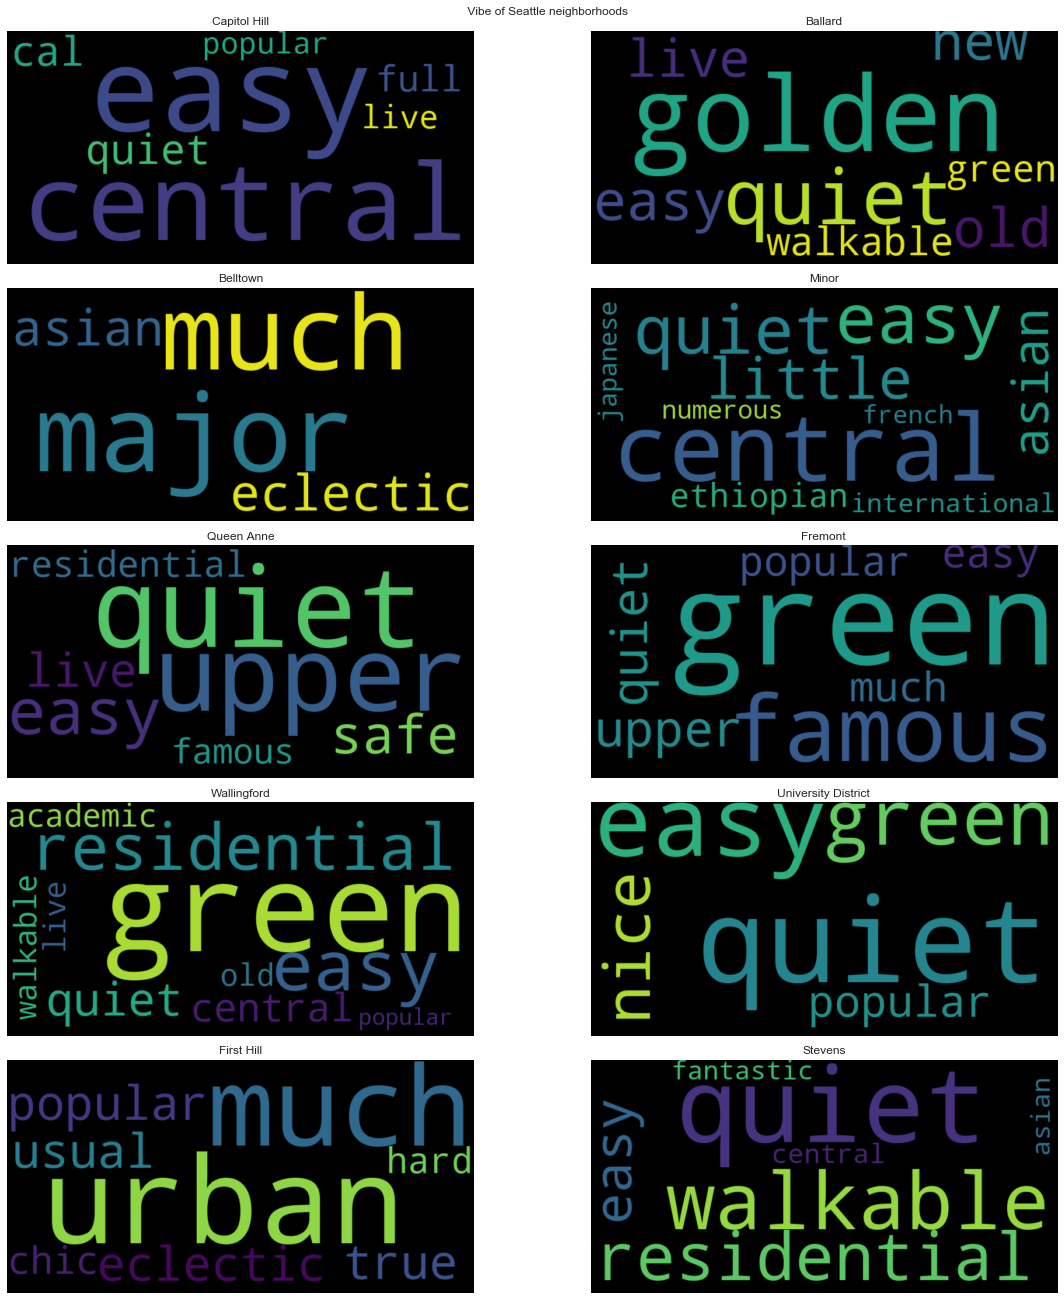

In [12]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18,18))
x = 0
y = 0
for k,v in neighbourhoods_keywords_dict.items():
   cloud = WordCloud(width=800, height=400)
   cloud.generate_from_frequencies(frequencies=v)
   axs[x][y].imshow(cloud, interpolation="bilinear")
   axs[x][y].title.set_text(k)
   axs[x][y].axis("off") 
   if y == 0:
    y = y + 1
   elif y == 1:
    y = 0
    x = x + 1
   
fig.tight_layout(pad=1.0)    
fig.suptitle("".join(["         Vibe of Seattle neighborhoods"]), y=1.00)
plt.show()

## Visulizations with comparative analysis

### Q: How Airbnb properties could affect the prices in Seattle and Boston?

#### 1. Influence of property type on Airbnb price

Text(0.5, 0.98, '         Effect of property type on price')

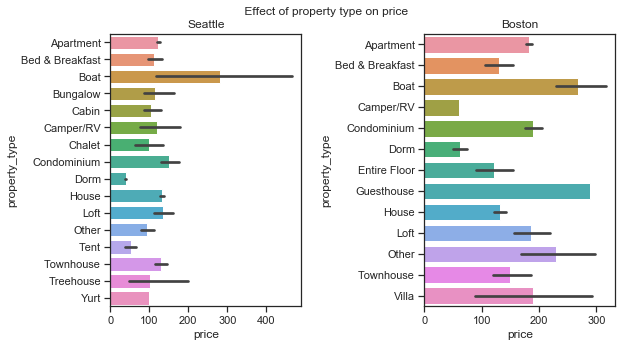

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
df_sea_fl_sorted = df_sea_fl.copy().sort_values(by='property_type', ascending=True, na_position='first')
df_bos_fl_sorted = df_bos_fl.copy().sort_values(by='property_type', ascending=True, na_position='first')

plt1=sns.catplot(x='price', y='property_type', orient='h', kind='bar', data=df_sea_fl_sorted, ax=axs[0])
plt2=sns.catplot(x='price', y='property_type', orient='h', kind='bar', data=df_bos_fl_sorted, ax=axs[1])
plt1.set_xticklabels(rotation =45, horizontalalignment='right')
plt2.set_xticklabels(rotation =45, horizontalalignment='right')

axs[0].title.set_text('Seattle')
axs[1].title.set_text('Boston')

plt.close(2)
plt.close(3)

fig.tight_layout(pad=2.0)
fig.suptitle("".join(["         Effect of property type on price"]), y=0.98)



#### 2.1 Influence of number of beds, bathrooms, bedrooms, accommodates on price in Seattle

Text(0.5, 1.02, 'Influence of number of beds, bathrooms, bedrooms, accommodates on price in Seattle')

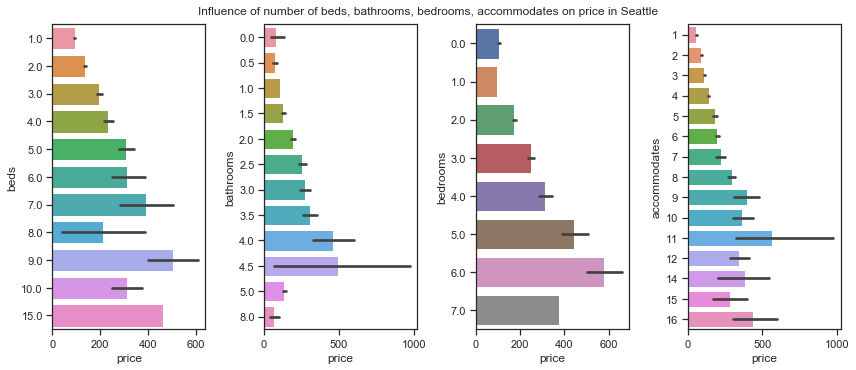

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,5))

plt1=sns.catplot(x='price', y='beds', orient ='h', kind ='bar', data= df_sea_fl, ax=axs[0])
plt2=sns.catplot(x='price', y='bathrooms', orient ='h', kind ='bar', data= df_sea_fl, ax=axs[1])
plt3=sns.catplot(x='price', y='bedrooms', orient ='h', kind ='bar', data= df_sea_fl, ax=axs[2])
plt4=sns.catplot(x='price', y='accommodates', orient ='h', kind ='bar', data= df_sea_fl, ax=axs[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)

fig.tight_layout()
fig.suptitle("\n".join(["Influence of number of beds, bathrooms, bedrooms, accommodates on price in Seattle"]), y=1.02)


#### 2.2 Influence of number of beds, bathrooms, bedrooms, accommodates on price in Boston

Text(0.5, 1.02, 'Influence of number of beds, bathrooms, bedrooms, accommodates on price in Boston')

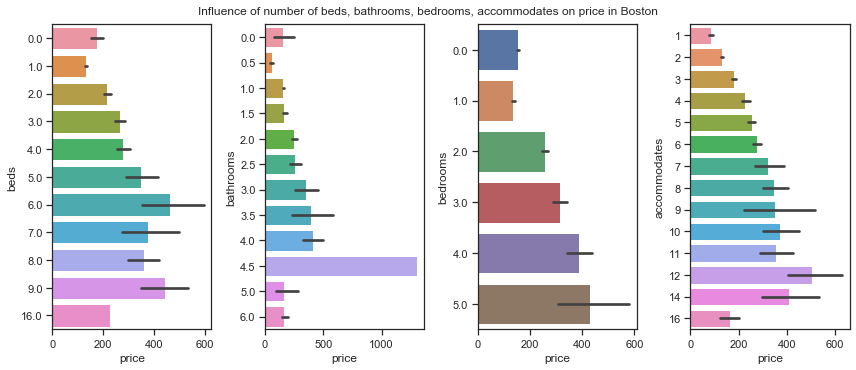

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,5))

plt1=sns.catplot(x='price', y='beds', orient ='h', kind ='bar', data= df_bos_fl, ax=axs[0])
plt2=sns.catplot(x='price', y='bathrooms', orient ='h', kind ='bar', data= df_bos_fl, ax=axs[1])
plt3=sns.catplot(x='price', y='bedrooms', orient ='h', kind ='bar', data= df_bos_fl, ax=axs[2])
plt4=sns.catplot(x='price', y='accommodates', orient ='h', kind ='bar', data= df_bos_fl, ax=axs[3])
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
fig.tight_layout()
fig.suptitle("\n".join(["Influence of number of beds, bathrooms, bedrooms, accommodates on price in Boston"]), y=1.02)

## Predictions using regression to determind the most important property of Airbnb listing

### Q: What are the most important properties of Airbnb listing that lead to a high review score

In [16]:
def clean_data(df):    
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    # Drop rows with missing overall review values
    df = df.dropna(subset=['overall_review_score'], axis=0)
    y = df['overall_review_score']
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    #    # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(['overall_review_score'], axis=1)

    return X, y

In [17]:
df_sea_final = df_sea_fl.copy()
df_bos_final = df_bos_fl.copy()

#Use the function to create X and y
X_sea, y_sea = clean_data(df_sea_final)
X_bos, y_bos = clean_data(df_bos_final)


C:\Users\joshu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [18]:
#Split into train and test 
X_train_sea, X_test_sea, y_train_sea, y_test_sea = train_test_split(X_sea, y_sea, test_size =.28, random_state=42)
X_train_bos, X_test_bos, y_train_bos, y_test_bos = train_test_split(X_bos, y_bos, test_size =.28, random_state=42)
# test_size =0.25

regressor_sea = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42, n_jobs=-1)
regressor_sea.fit(X_train_sea, y_train_sea) 
y_train_sea_preds = regressor_sea.predict(X_train_sea)
y_test_sea_preds = regressor_sea.predict(X_test_sea)
mse_train_sea = mean_squared_error(y_train_sea, y_train_sea_preds)
mse_test_sea = mean_squared_error(y_test_sea, y_test_sea_preds)
r2_score_train_sea = r2_score(y_train_sea, y_train_sea_preds)
r2_score_test_sea = r2_score(y_test_sea, y_test_sea_preds)

regressor_bos = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=42, n_jobs=-1)
regressor_bos.fit(X_train_bos, y_train_bos) 
y_train_bos_preds = regressor_bos.predict(X_train_bos)
y_test_bos_preds = regressor_bos.predict(X_test_bos)
mse_train_bos = mean_squared_error(y_train_bos, y_train_bos_preds)
mse_test_bos = mean_squared_error(y_test_bos, y_test_bos_preds)
r2_score_train_bos = r2_score(y_train_bos, y_train_bos_preds)
r2_score_test_bos = r2_score(y_test_bos, y_test_bos_preds)

print('Seattle data: mean_squared_error train: %.3f, test: %.3f' % (mse_train_sea, mse_test_sea))
print('Seattle data: r2_score train: %.3f, test: %.3f' % (r2_score_train_sea, r2_score_test_sea))
print('Boston data: mean_squared_error train: %.3f, test: %.3f' % (mse_train_bos, mse_test_bos))
print('Boston data: r2_score train: %.3f, test: %.3f' % (r2_score_train_bos, r2_score_test_bos))

Seattle data: mean_squared_error train: 0.252, test: 2.083
Seattle data: r2_score train: 0.916, test: 0.343
Boston data: mean_squared_error train: 0.326, test: 2.801
Boston data: r2_score train: 0.913, test: 0.378


Text(0.5, 0.99, '                 Most important features to result in high review score')

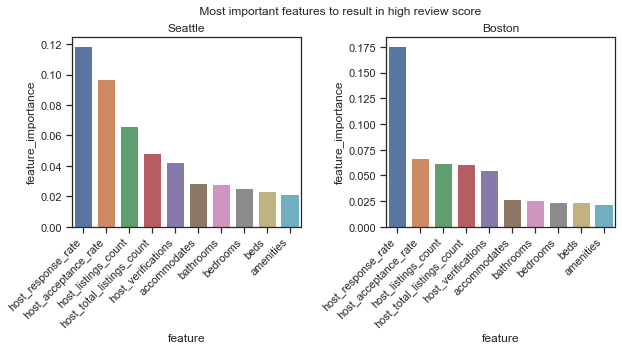

In [19]:
result_sea = pd.DataFrame({'feature': X_sea.columns, 'feature_importance': regressor_sea.feature_importances_})
result_sea_sorted = result_sea.sort_values(by='feature_importance',ascending=False)[:10]
result_bos = pd.DataFrame({'feature': X_bos.columns, 'feature_importance': regressor_bos.feature_importances_})
result_bos_sorted = result_bos.sort_values(by='feature_importance',ascending=False)[:10]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,5))
plt1=sns.catplot(x='feature', y='feature_importance', kind='bar', data=result_sea_sorted, ax=axs[0])
plt2=sns.catplot(x='feature', y='feature_importance', kind='bar', data=result_bos_sorted, ax=axs[1])
axs[0].set_xticklabels(result_sea.feature, rotation =45, horizontalalignment='right')
axs[1].set_xticklabels(result_bos.feature, rotation =45, horizontalalignment='right')
axs[0].title.set_text('Seattle')
axs[1].title.set_text('Boston')

plt.close(2)
plt.close(3)

fig.tight_layout(pad=2.0)
fig.suptitle("".join(["                 Most important features to result in high review score"]), y=0.99)
